In [3]:
# Importy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import keras

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

In [4]:
# Przygotowanie
def printmd(string):   
    display(Markdown(string))
    
np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [6]:
# Wczytanie zdjęć
images = []
dirp = "kaggle/input/fruit-recognition/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
df = pd.DataFrame(images, columns = ["fruit", "path"])

from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

df

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


fruit                                               path  label
0            Apple  kaggle/input/fruit-recognition/Apple/Apple F\A...      0
1            Apple  kaggle/input/fruit-recognition/Apple/Apple D\a...      0
2             Kiwi  kaggle/input/fruit-recognition/Kiwi/Total Numb...      4
3      Pomegranate  kaggle/input/fruit-recognition/Pomegranate\Pom...     12
4            Guava  kaggle/input/fruit-recognition/Guava/guava tot...      3
...            ...                                                ...    ...
70544        Guava  kaggle/input/fruit-recognition/Guava/Guava tot...      3
70545        Mango  kaggle/input/fruit-recognition/Mango\Mango0022...      5
70546         Kiwi  kaggle/input/fruit-recognition/Kiwi/Total Numb...      4
70547         Kiwi  kaggle/input/fruit-recognition/Kiwi/Total Numb...      4
70548  Pomegranate  kaggle/input/fruit-recognition/Pomegranate\Pom...     12

[70549 rows x 3 columns]

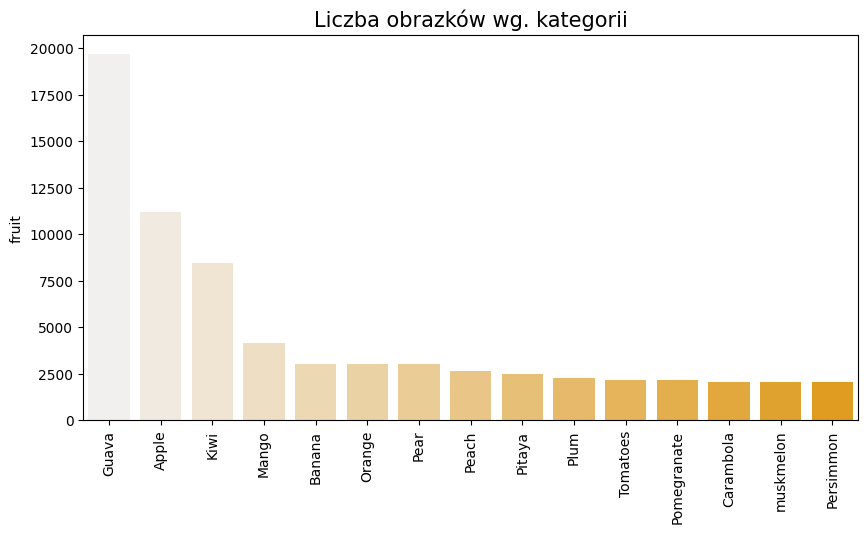

In [18]:
# Nowy wykres
import matplotlib.pyplot as plt
import seaborn as sns
fc = df["fruit"].value_counts()
plt.figure(figsize=(10, 5))
orange_palette = sns.light_palette("orange", len(fc.index))
sns.barplot(x=fc.index, y=fc, palette=orange_palette)
for index, value in enumerate(fc):
    plt.text(index, value, f"{value}", color='white', ha="center", va="bottom")
plt.title("Liczba obrazków wg. kategorii", fontsize=15)
plt.xticks(rotation=90)
plt.show()


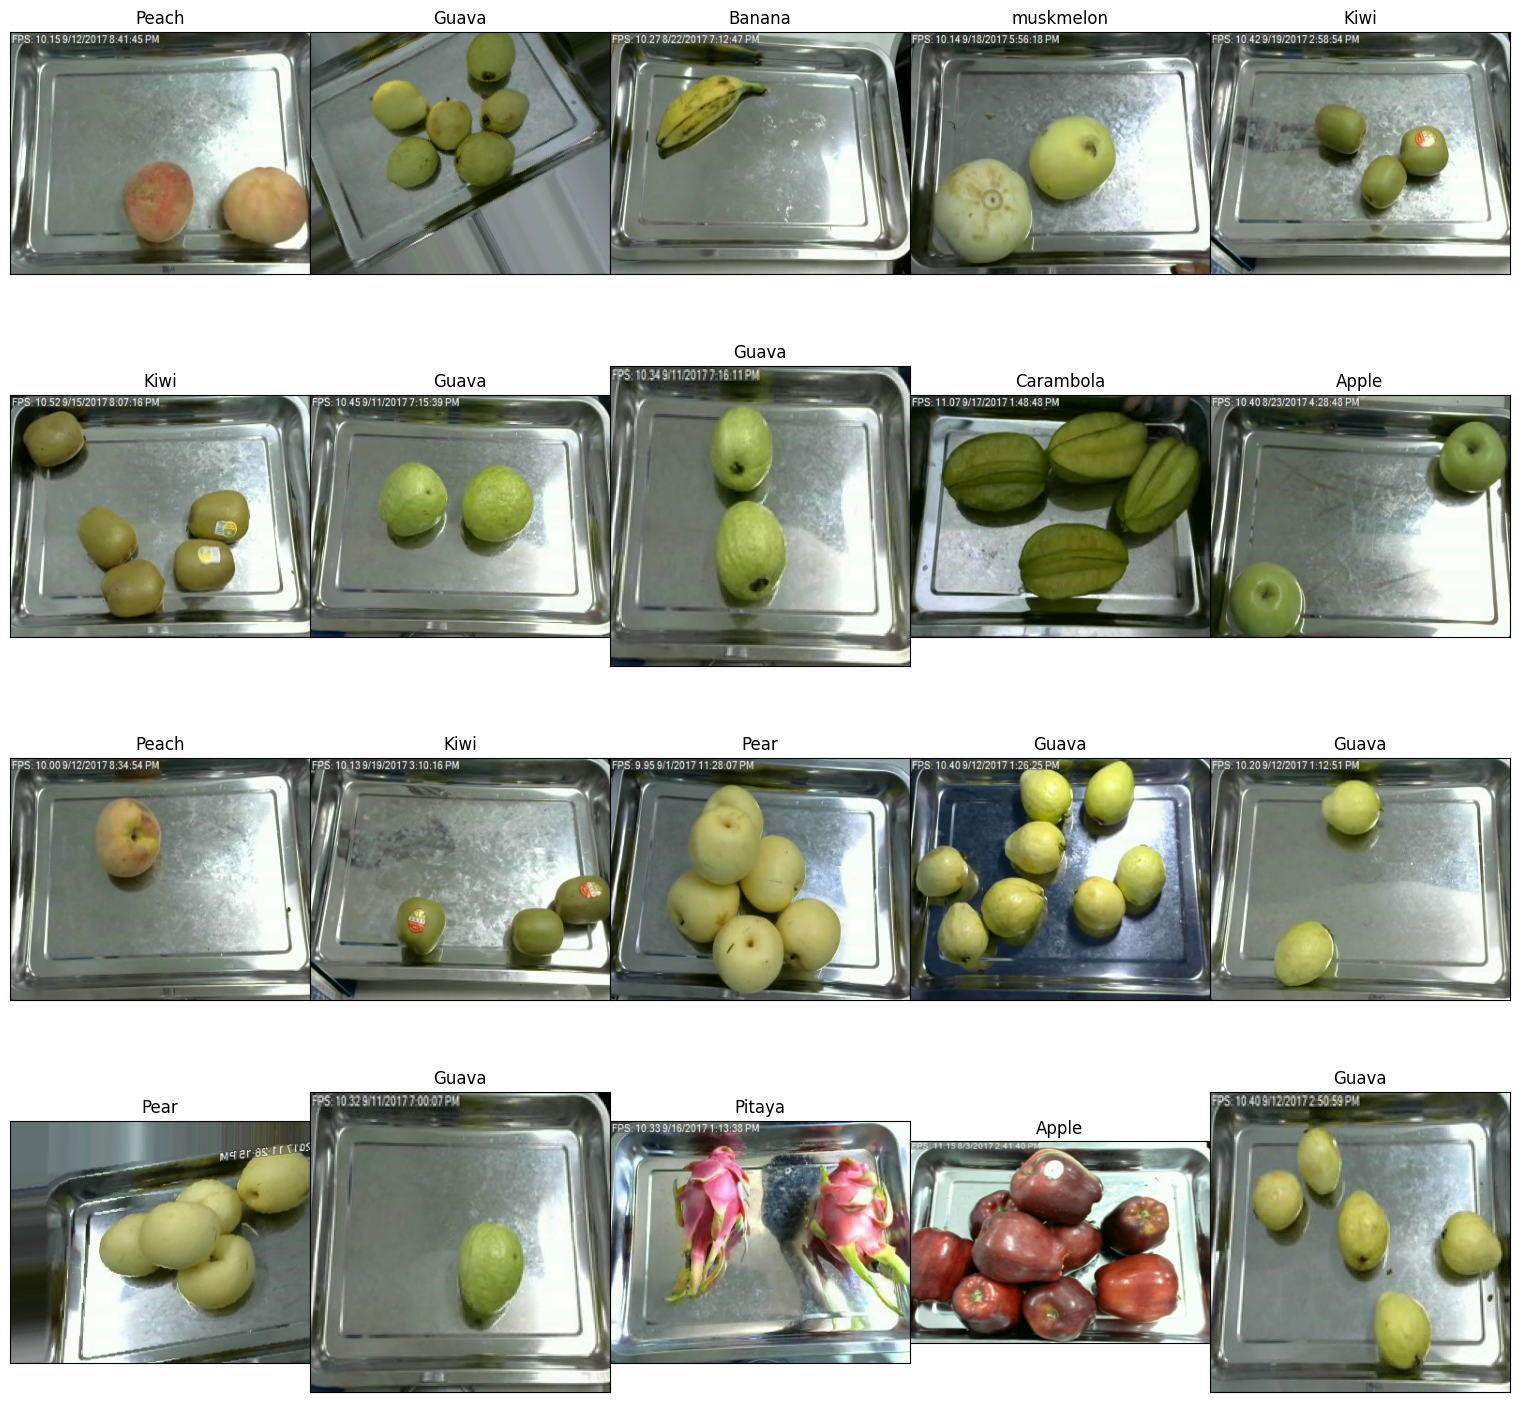

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i+20]))
    ax.set_title(df.fruit[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

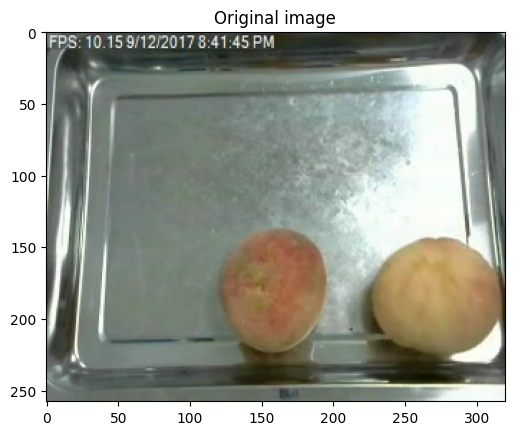

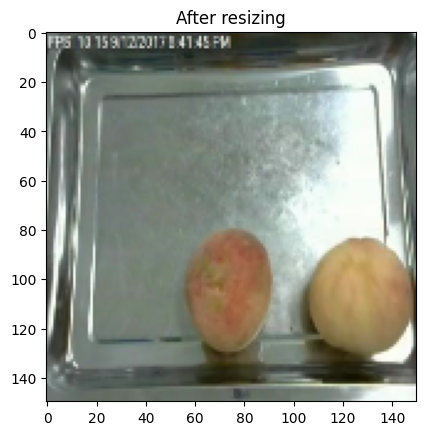

In [9]:
img = plt.imread(df.path[20])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

In [10]:
def cut_df(df, number_of_parts, part):

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):

    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [11]:
def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [12]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [13]:
model = create_model()
hists = []

divisor = 5

start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

Epoch 1/100
100/100 [==============================] - 147s 1s/step - loss: 2.3910 - accuracy: 0.2664 - val_loss: 2.1767 - val_accuracy: 0.2721
Epoch 2/100
100/100 [==============================] - 135s 1s/step - loss: 2.0221 - accuracy: 0.3316 - val_loss: 1.7405 - val_accuracy: 0.3600
Epoch 3/100
100/100 [==============================] - 126s 1s/step - loss: 1.4111 - accuracy: 0.5273 - val_loss: 1.3249 - val_accuracy: 0.6279
Epoch 4/100
100/100 [==============================] - 129s 1s/step - loss: 0.8837 - accuracy: 0.6944 - val_loss: 0.6782 - val_accuracy: 0.7399
Epoch 5/100
100/100 [==============================] - 129s 1s/step - loss: 0.5748 - accuracy: 0.7930 - val_loss: 0.4130 - val_accuracy: 0.8448
Epoch 6/100
100/100 [==============================] - 129s 1s/step - loss: 0.4972 - accuracy: 0.8382 - val_loss: 1.1262 - val_accuracy: 0.6683
Epoch 7/100
100/100 [==============================] - 128s 1s/step - loss: 0.6314 - accuracy: 0.7998 - val_loss: 0.3355 - val_accuracy:

In [19]:
gc.collect()

12438

In [20]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")

Time to train the model: 7809 seconds


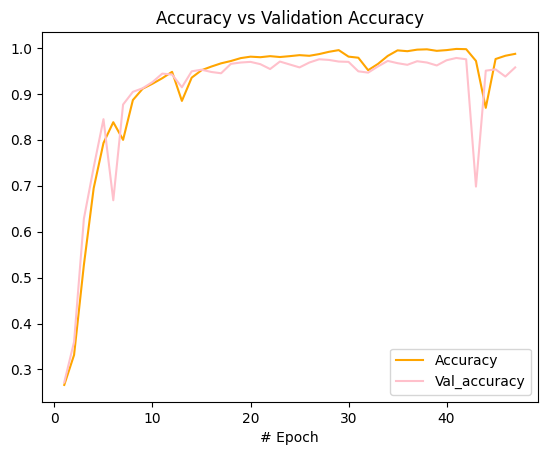

In [35]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
colors = ['#FFA500', '#FFC0CB']
ax = hist_df.plot(x="# Epoch", y="Accuracy", color=colors[0], title="Accuracy vs Validation Accuracy")
hist_df.plot(x="# Epoch", y="Val_accuracy", color=colors[1], ax=ax)
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [36]:
import warnings
warnings.filterwarnings("ignore")

X, y = load_img(cut_df(df, 20, 20))
#pred = model.predict_classes(X)
pred = np.argmax(model.predict(X), axis=1)
y_test = to_categorical(y)

display_stats(y_test, pred)

111/111 [==============================] - 8s 73ms/step
### Result of the predictions using 3527 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       573
           1       0.92      0.91      0.91       149
           2       0.96      0.97      0.97       107
           3       0.99      1.00      0.99      1022
           4       0.99      1.00      0.99       411
           5       0.98      0.91      0.94       183
           6       0.94      1.00      0.97       149
           7       0.96      0.96      0.96       148
           8       0.98      0.90      0.94       144
           9       0.99      0.92      0.95       111
          10       0.95      0.99      0.97        97
          11       0.99      0.99      0.99       119
          12       0.93      0.93      0.93       105
          13       0.97      0.97      0.97       117
          14       0.87      0.87      0.87        92

# Accuracy: 0.96598

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


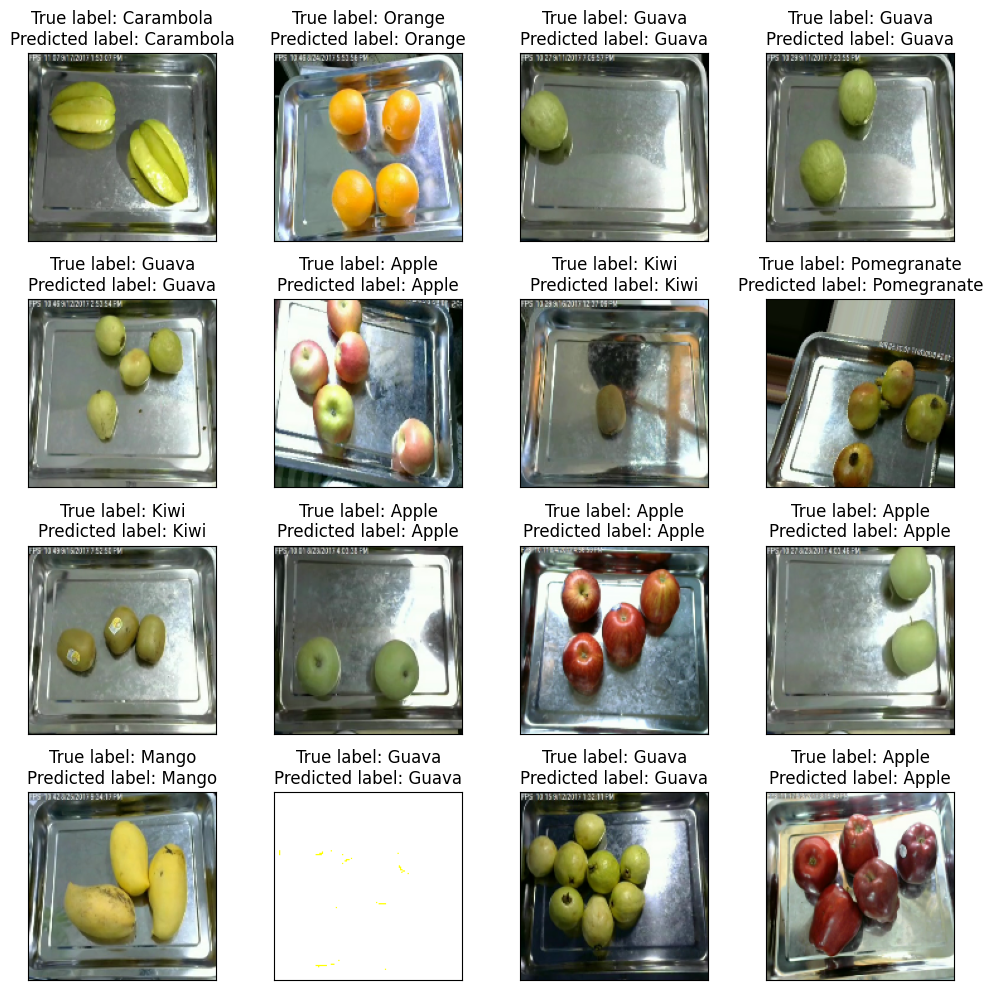

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()